In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
np.set_printoptions(suppress=True,linewidth=250,threshold=250)

In [2]:
def split_data(data, ratio):
    '''
    Create randomized train set and test set based on the ratio
    ---
    Input:
        data[pd df]     data
        ratio[int]      test:train ratio
    Output:
        testdata[pd df]
        traindata[pd df]
    '''
    # Generate random indices
    indices = np.random.permutation(len(data))
    # Calculate how many entries the test data will have
    test_size = int(len(data)*ratio)
    # Get the test indices from the randomly generated indices
    test_indices = indices[:test_size]
    # Get the train indices from the randomly generated indices
    train_indices = indices[test_size:]
    # Return the data corresponding to the indices
    return data.iloc[test_indices], data.iloc[train_indices]

In [3]:
# Read own data
data = pd.read_feather('data.feather')

In [4]:
'''
csv_data = pd.read_csv('datafra.csv', names=['1', '2', '3', '4', '5', '6', '7', '8', '9']).reset_index()
csv_labels = pd.read_csv('datacur.csv', names=['Curvature']).reset_index()
data = csv_labels.merge(csv_data, on='index').drop(columns=['index'], axis=1)
#'''

"\ncsv_data = pd.read_csv('datafra.csv', names=['1', '2', '3', '4', '5', '6', '7', '8', '9']).reset_index()\ncsv_labels = pd.read_csv('datacur.csv', names=['Curvature']).reset_index()\ndata = csv_labels.merge(csv_data, on='index').drop(columns=['index'], axis=1)\n#"

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Scale Data
# scaler = StandardScaler()
# data = pd.DataFrame(scaler.fit_transform(data))
# Split data
# test_set, train_set = split_data(data, 0.2)
train_set = data.copy()
test_set = data.copy()

In [5]:
print(train_set.iloc[10000,:])

Curvature    0.767562
1            0.000000
2            0.075000
3            0.494000
4            0.547800
5            0.954900
6            1.000000
7            1.000000
8            1.000000
9            1.000000
Name: 10000, dtype: float64


In [6]:
# Split the training and test data into labels (first column) and data
test_labels = np.round(test_set.iloc[:, 0].to_numpy(),3)
test_data = np.round(test_set.iloc[:, 1:].to_numpy(),3)
train_labels = np.round(train_set.iloc[:, 0].to_numpy(),3)
train_data = np.round(train_set.iloc[:, 1:].to_numpy(),3)
#train_data = np.reshape(train_data,(len(train_data),3,3))
scaler = StandardScaler()
train_labels=(train_labels-min(train_labels))/(max(train_labels)-min(train_labels))
test_labels=(test_labels-min(train_labels))/(max(train_labels)-min(train_labels))

In [7]:
print(train_labels)

[0.75788436 0.75755585 0.75755585 ... 0.1435611  0.1435611  0.14388962]


In [8]:
print(train_labels.shape)

(186912,)


In [9]:
print(train_data)

[[0.    0.    0.    ... 0.038 0.784 1.   ]
 [0.    0.    0.    ... 0.784 1.    1.   ]
 [0.    0.    0.    ... 1.    1.    1.   ]
 ...
 [0.    0.    0.    ... 1.    1.    1.   ]
 [0.    0.    0.004 ... 1.    1.    1.   ]
 [0.    0.004 0.034 ... 1.    1.    1.   ]]


In [10]:
print(train_data.shape)

(186912, 9)


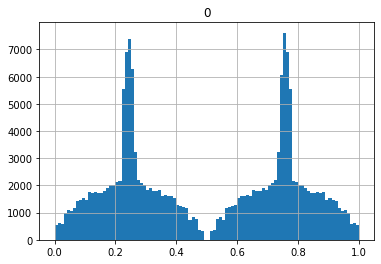

In [11]:
import matplotlib.pyplot as plt
pd.DataFrame(train_labels).hist(bins=100)
plt.show()

In [13]:
# Build keras model
'''
model = tf.keras.Sequential([
    layers.Input(shape=(9,)),
    layers.Dense(100, activation='relu'),
    layers.Dense(1, activation='linear')
])
'''
inputs = layers.Input(shape=(9,))
#flatten = layers.Flatten()(inputs)
dense1 = layers.Dense(10, activation='relu')(inputs)
dense2 = layers.Dense(10, activation='relu')(dense1)
dense3 = layers.Dense(10, activation='relu')(dense2)
outputs = layers.Dense(1, activation='linear')(dense3)
model = keras.Model(inputs=inputs, outputs=outputs, name='kerasmodel')
model.summary()


# Compile model
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

Model: "kerasmodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense (Dense)                (None, 10)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [14]:
from tqdm.keras import TqdmCallback
# Fit Data
model.fit(train_data, train_labels, verbose=0, callbacks=[TqdmCallback(verbose=1)], epochs=1000, batch_size=8192, validation_split=0.2)

Using TensorFlow backend.


In [15]:
print(model.predict(train_data[0:1]))

[[0.50568134]]


In [21]:
#test_predictions = model.predict(test_data).flatten()
train_predictions = model.predict(train_data).flatten()
print(train_predictions)

[0.50568134 0.51303154 0.51528704 ... 0.5055957  0.5056707  0.5050677 ]


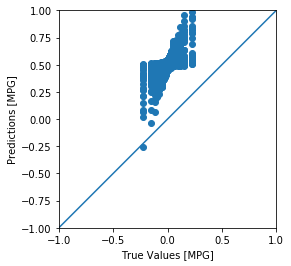

In [22]:
import matplotlib.pyplot as plt
a = plt.axes(aspect='equal')
#plt.scatter(test_labels, test_predictions)
plt.scatter(train_labels, train_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [-1, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
